# Preamble

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as ss
import scipy.special as ssp
import pymc as pm
import arviz as az
import pytensor.tensor as at
import pytensor.tensor.extra_ops as ate
import corner

# Data Generation
$$
x \sim \mathcal{N}(\mu_{p,x}, \sigma_{p,x}), ~ y \sim \mathcal{N}(\mu_{p,y}, \sigma_{p,y})
$$

$$
x_{obs}, y_{obs} \sim MVN(x,y,Cov)
$$

where

$$
Cov = 
\begin{pmatrix}
\sigma_x^2 & r\sigma_x \sigma_y \\
r\sigma_x \sigma_y & \sigma_y^2
\end{pmatrix}
$$

In [2]:
Nobs = 10000

mupxt = 0
sigmapxt = 1
mupyt = 10
sigmapyt = 2

x = np.random.normal(mupxt, sigmapxt, Nobs)
y = np.random.normal(mupyt, sigmapyt, Nobs)

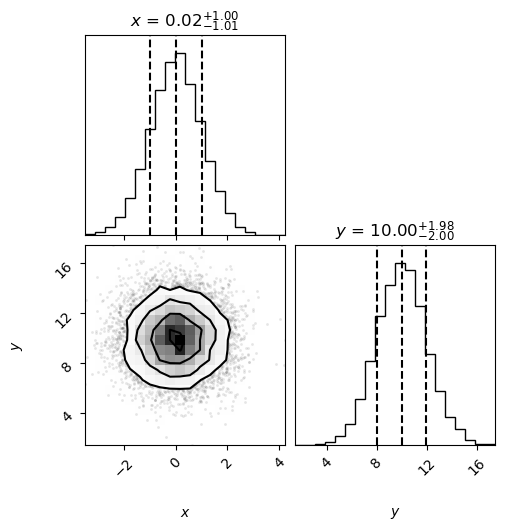

In [3]:
data = np.array([x,y]).T
figure = corner.corner(
        data,
        labels=[
            r"$x$",
            r"$y$",
        ],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )

In [4]:
sigmax = 1
sigmay = 1
r = 0.9
cov = [[sigmax**2, r*sigmax*sigmay], [r*sigmax*sigmay, sigmay**2]]
means = np.stack((x, y), axis=1)

samples = np.array([np.random.multivariate_normal(mean, cov) for mean in means])

xo = samples[:, 0]
yo = samples[:, 1]

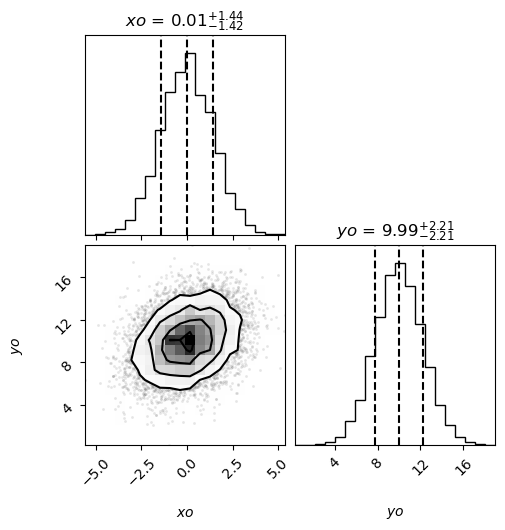

In [5]:
data = np.array([xo,yo]).T
figure = corner.corner(
        data,
        labels=[
            r"$xo$",
            r"$yo$",
        ],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )

# Inference
### with xo and yo

$$
P(\mu_{xp}, \sigma_{xp}, \mu_{yp}, \sigma_{yp}|\vec{x_o}, \vec{y_o}) \propto \pi(\mu_{xp}) \pi(\sigma_{xp}) \pi(\mu_{yp}) \pi(\sigma_{yp}) \prod_i \int_{x,y} dx dy ~ P(x_{oi},y_{oi}|x,y) ~ P(x|\mu_{xp}, \sigma_{xp}) ~ P(y|\mu_{yp}, \sigma_{yp})
$$

$$
P(\mu_{xp}, \sigma_{xp}, \mu_{yp}, \sigma_{yp}|\vec{x_o}, \vec{y_o}) \propto \pi(\mu_{xp}) \pi(\sigma_{xp}) \pi(\mu_{yp}) \pi(\sigma_{yp}) \prod_i \int_{x,y} dx dy ~ MVN(x_{oi},y_{oi}|x,y,Cov) ~ N(x|\mu_{xp}, \sigma_{xp}) ~ N(y|\mu_{yp}, \sigma_{yp})
$$

Note that $Cov$ is not function of x and y.

The integral simplifies to:
$$
P(\mu_{xp}, \sigma_{xp}, \mu_{yp}, \sigma_{yp}|\vec{x_o}, \vec{y_o}) \propto \pi(\mu_{xp}) \pi(\sigma_{xp}) \pi(\mu_{yp}) \pi(\sigma_{yp}) \prod_i ~ MVN(x_{oi},y_{oi}|\mu_{xp},\mu_{yp},Cov+Cov_p)
$$

where,

$$
Cov_p = \begin{pmatrix}
\sigma_{xp}^2 & 0 \\
0 & \sigma_{yp}^2
\end{pmatrix}
$$

In [6]:
def make_model(xo, yo, Cov):

    with pm.Model() as model:        
        mupx = pm.Uniform('mupx', -3, 3)
        sigmapx = pm.Uniform('sigmapx', 0.01, 3)
        mupy = pm.Uniform('mupy', 5, 15)
        sigmapy = pm.Uniform('sigmapy', 0.1, 4)

        mu = at.stack([mupx, mupy])

        diag_cov = at.diag(at.stack([sigmapx**2, sigmapy**2]))

        total_cov = Cov + diag_cov

        observed = np.stack([xo, yo], axis=-1)

        pm.MvNormal('likelihood', mu=mu, cov=total_cov, observed=observed)

    return model

In [7]:
with make_model(xo, yo, cov) as model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mupx, sigmapx, mupy, sigmapy]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


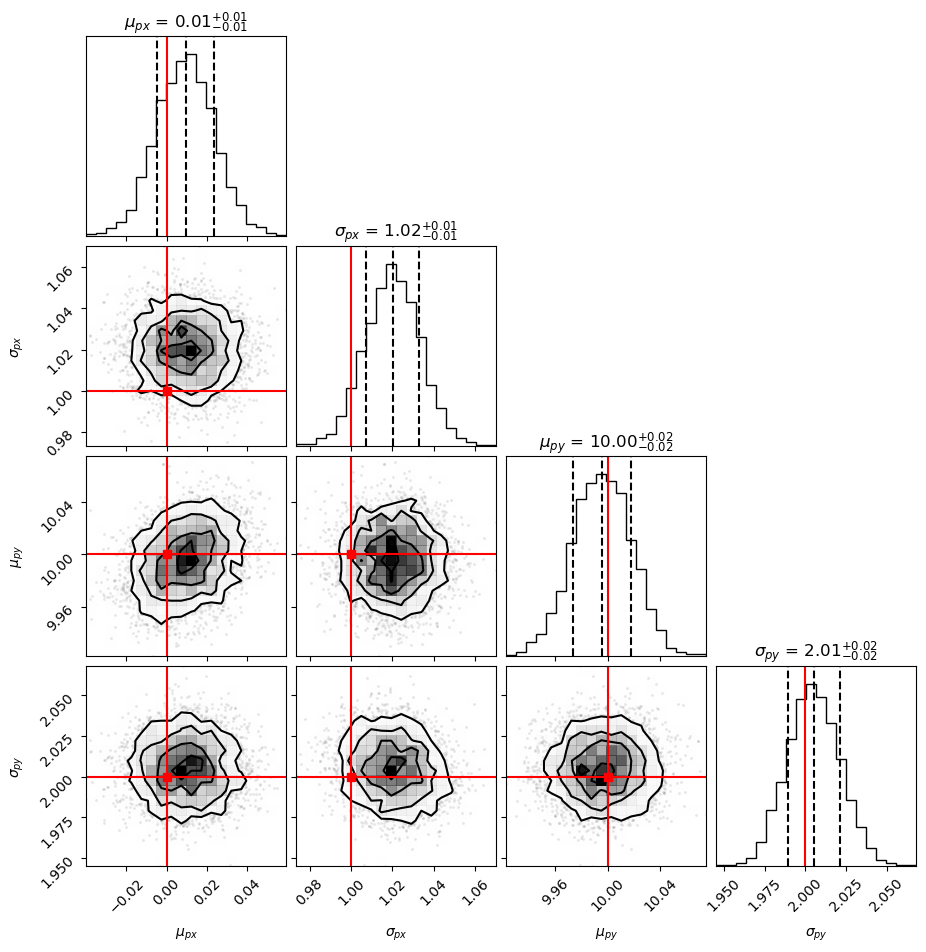

In [8]:
data = np.array([np.array(trace.posterior.mupx).flatten(),np.array(trace.posterior.sigmapx).flatten(),np.array(trace.posterior.mupy).flatten(),np.array(trace.posterior.sigmapy).flatten()]).T
figure = corner.corner(
        data,
        labels=[
            r"$\mu_{px}$",
            r"$\sigma_{px}$",
            r"$\mu_{py}$",
            r"$\sigma_{py}$",
        ],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )
true = np.array([mupxt, sigmapxt, mupyt, sigmapyt])
# Extract the axes
axes = np.array(figure.axes).reshape((len(true), len(true)))

# Loop over the diagonal
for i in range(len(true)):
    ax = axes[i, i]
    ax.axvline(true[i], color="r")



# Loop over the histograms
for yi in range(len(true)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true[xi], color="r")
        ax.axhline(true[yi], color="r")
        ax.plot(true[xi], true[yi], "sr")

### with yo only
Now let's infer $\mu_{py}$ and $\sigma_{py}$ only from yo, forgetting xo exists.
$$
P(\mu_{yp}, \sigma_{yp}|\vec{y_o}) \propto \pi(\mu_{yp}) \pi(\sigma_{yp}) \prod_i \int_y dy ~ P(y_{oi}|y) ~ P(y|\mu_{yp}, \sigma_{yp})
$$

$$
P(\mu_{yp}, \sigma_{yp}|\vec{y_o}) \propto \pi(\mu_{yp}) \pi(\sigma_{yp}) \prod_i \int_y dy ~ N(y_{oi}|y,\sigma_y) ~ N(y|\mu_{yp}, \sigma_{yp})
$$

$$
P(\mu_{yp}, \sigma_{yp}|\vec{y_o}) \propto \pi(\mu_{yp}) \pi(\sigma_{yp}) \prod_i N(y_{oi}|\mu_{yp},\sqrt{\sigma_y^2+\sigma_{yp}^2})
$$

In [9]:
def make_model_yo(yo, sigmay):

    with pm.Model() as model:        
        mupy = pm.Uniform('mupy', 5, 15)
        sigmapy = pm.Uniform('sigmapy', 0.1, 4)

        pm.Normal('likelihood', mu=mupy, sigma=at.sqrt(sigmay**2+sigmapy**2), observed=yo)

    return model

In [10]:
with make_model_yo(yo, sigmay) as model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mupy, sigmapy]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


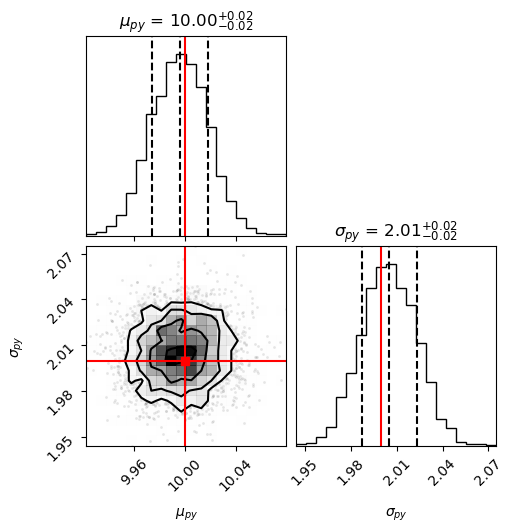

In [11]:
data = np.array([np.array(trace.posterior.mupy).flatten(),np.array(trace.posterior.sigmapy).flatten()]).T
figure = corner.corner(
        data,
        labels=[
            r"$\mu_{py}$",
            r"$\sigma_{py}$",
        ],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )
true = np.array([mupyt, sigmapyt])
# Extract the axes
axes = np.array(figure.axes).reshape((len(true), len(true)))

# Loop over the diagonal
for i in range(len(true)):
    ax = axes[i, i]
    ax.axvline(true[i], color="r")



# Loop over the histograms
for yi in range(len(true)):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(true[xi], color="r")
        ax.axhline(true[yi], color="r")
        ax.plot(true[xi], true[yi], "sr")